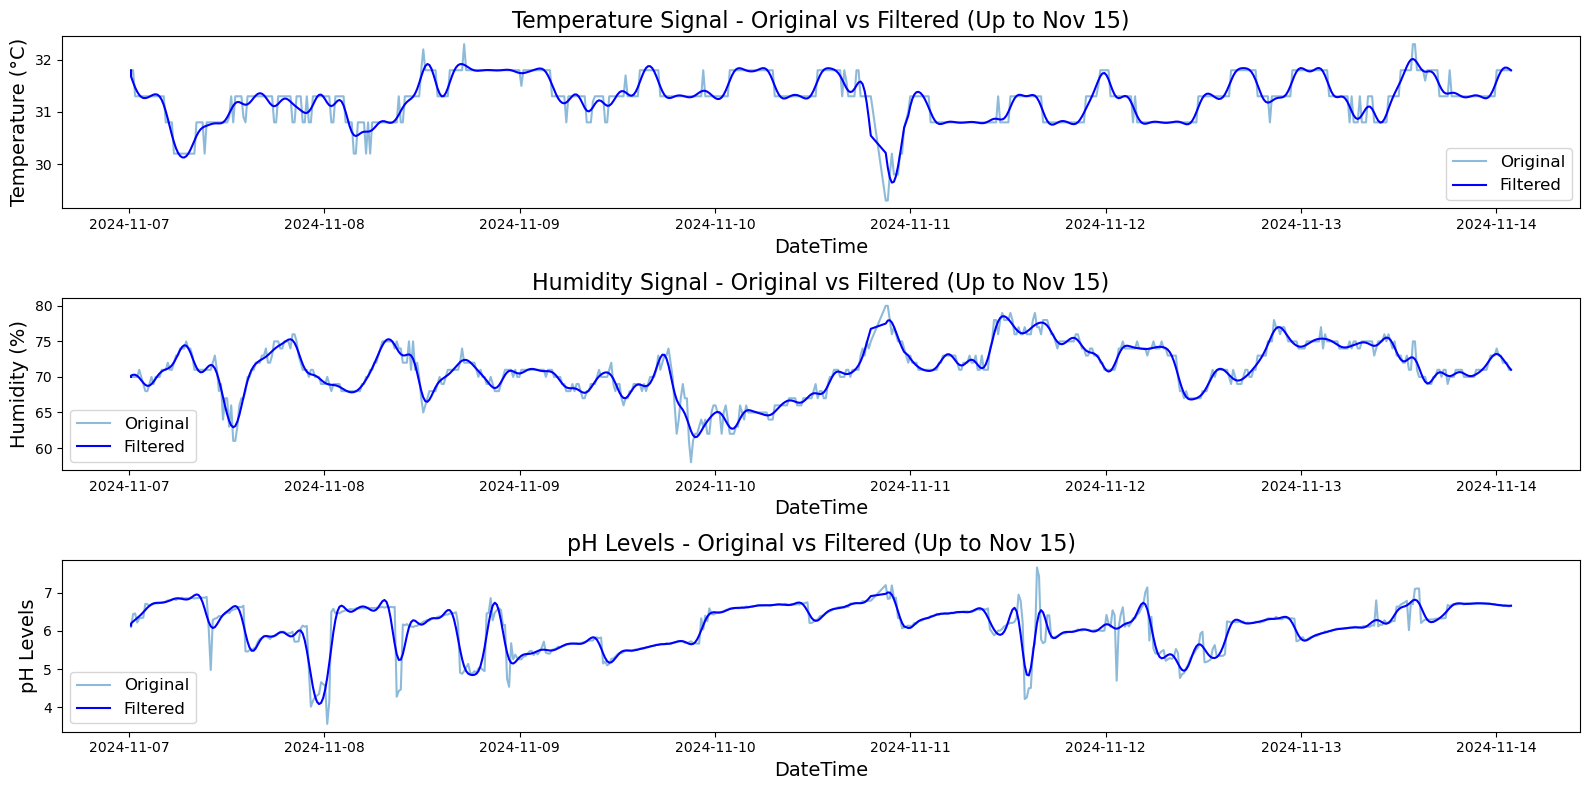

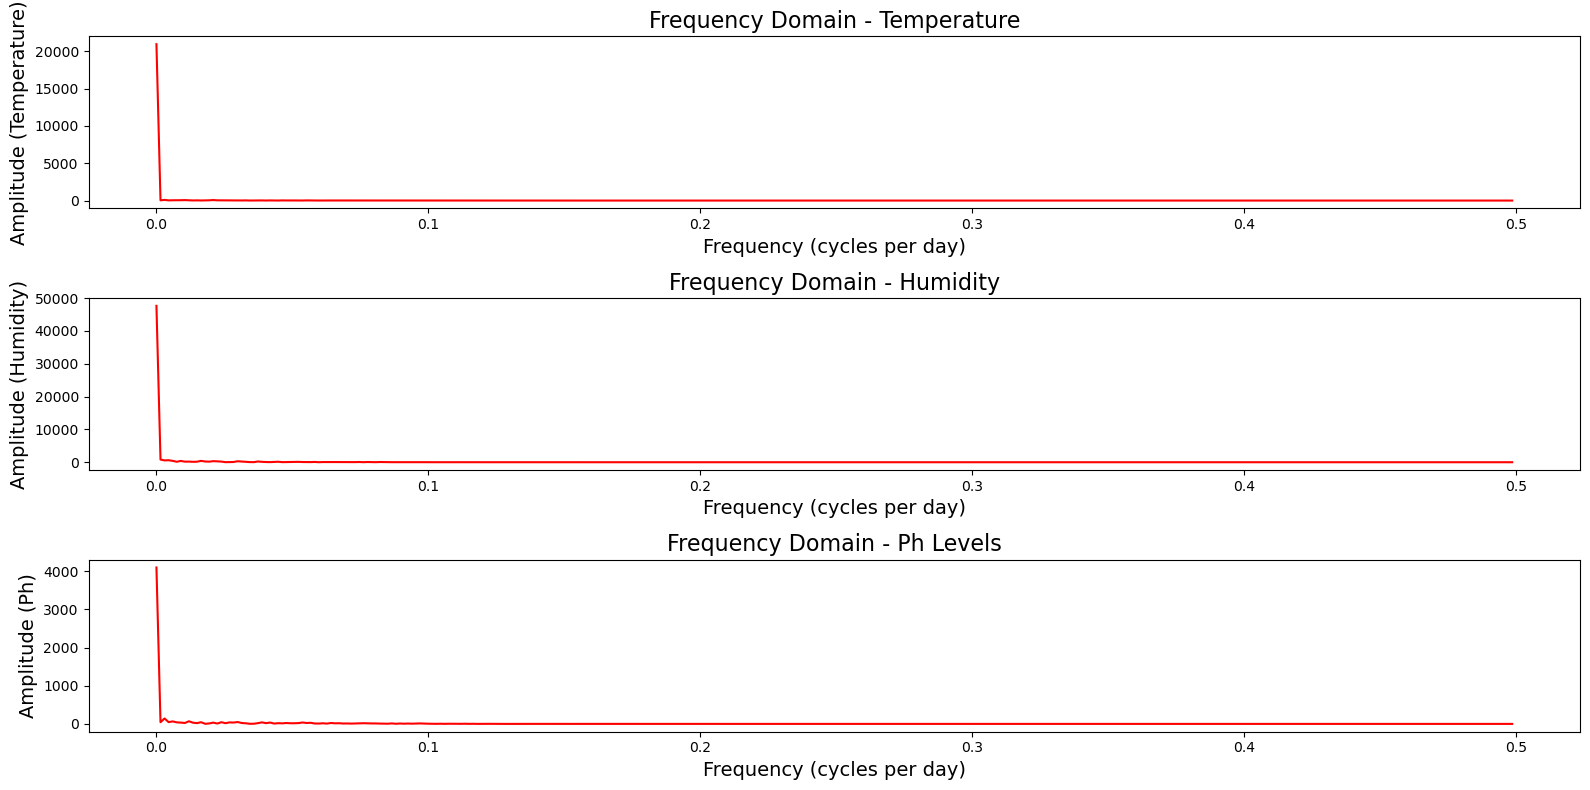

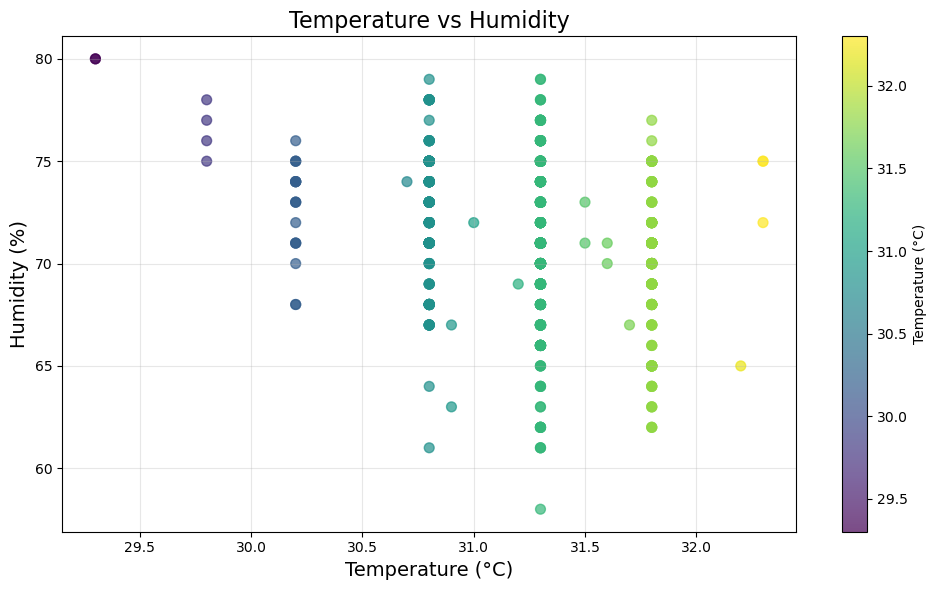

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the dataset
file_path = r'C:\Users\conra\Downloads\Temperature and humidity DATA.xlsx'
data = pd.read_excel(file_path, sheet_name="Sheet1")

# Combine DATE and TIME columns into a single DateTime column
data['DateTime'] = pd.to_datetime(data['DATE'].astype(str) + ' ' + data['TIME'].astype(str), errors='coerce')

# Drop the original DATE and TIME columns
data.drop(columns=['DATE', 'TIME'], inplace=True)

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Ensure numerical columns are of numeric type
for col in ['TEMPERATURE', 'HUMIDITY', 'Ph']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing values with column mean
data[['TEMPERATURE', 'HUMIDITY', 'Ph']] = data[['TEMPERATURE', 'HUMIDITY', 'Ph']].fillna(data[['TEMPERATURE', 'HUMIDITY', 'Ph']].mean())

# Define the Butterworth lowpass filter functions
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Sampling rate and cutoff frequency
fs = 1  # Assuming 1 sample per day based on dataset frequency
cutoff_frequency = 0.1  # Example cutoff frequency

# Filter data to only include entries up to November 15
data_limited = data[data.index <= '2024-11-15']

# Re-apply lowpass filter to the limited dataset
filtered_temperature_limited = lowpass_filter(data_limited['TEMPERATURE'].to_numpy(), cutoff_frequency, fs)
filtered_humidity_limited = lowpass_filter(data_limited['HUMIDITY'].to_numpy(), cutoff_frequency, fs)
filtered_ph_limited = lowpass_filter(data_limited['Ph'].to_numpy(), cutoff_frequency, fs)

# Visualization: Original vs Filtered Signals for the limited date range
plt.figure(figsize=(16, 8))

for i, (signal_data, filtered_data, title, ylabel) in enumerate(zip(
        [data_limited['TEMPERATURE'], data_limited['HUMIDITY'], data_limited['Ph']],
        [filtered_temperature_limited, filtered_humidity_limited, filtered_ph_limited],
        ['Temperature Signal - Original vs Filtered (Up to Nov 15)',
         'Humidity Signal - Original vs Filtered (Up to Nov 15)',
         'pH Levels - Original vs Filtered (Up to Nov 15)'],
        ['Temperature (°C)', 'Humidity (%)', 'pH Levels'])):

    plt.subplot(3, 1, i + 1)
    plt.plot(data_limited.index, signal_data, label='Original', alpha=0.5)
    plt.plot(data_limited.index, filtered_data, label='Filtered', color='blue')
    plt.title(title, fontsize=16)
    plt.xlabel('DateTime', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Perform FFT on the filtered signals
fft_temperature_limited = np.fft.fft(filtered_temperature_limited)
fft_humidity_limited = np.fft.fft(filtered_humidity_limited)
fft_ph_limited = np.fft.fft(filtered_ph_limited)

# Compute frequencies corresponding to the FFT results
n = len(data_limited)
frequencies = np.fft.fftfreq(n, d=1/fs)  # d=1/fs is the sampling interval

# Visualization: Frequency domain representation
plt.figure(figsize=(16, 8))

for i, (fft_data, title, ylabel) in enumerate(zip(
        [fft_temperature_limited, fft_humidity_limited, fft_ph_limited],
        ['Frequency Domain - Temperature',
         'Frequency Domain - Humidity',
         'Frequency Domain - Ph Levels'],
        ['Amplitude (Temperature)', 'Amplitude (Humidity)', 'Amplitude (Ph)'])):

    plt.subplot(3, 1, i + 1)
    plt.plot(frequencies[:n // 2], np.abs(fft_data)[:n // 2], color='red')  # Plot only positive frequencies
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency (cycles per day)', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

plt.tight_layout()
plt.show()

# Scatter plot: Temperature vs Humidity
plt.figure(figsize=(10, 6))
plt.scatter(data_limited['TEMPERATURE'], data_limited['HUMIDITY'], alpha=0.7, c=data_limited['TEMPERATURE'], cmap='viridis', s=50)
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature vs Humidity', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Humidity (%)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
